#  Разработка модульного чат-бота с применением моделей 🤗 Transformers

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://huggingface.co/models?pipeline_tag=token-classification&sort=trending
* https://huggingface.co/docs/transformers/training
* https://github.com/seatgeek/thefuzz
* https://github.com/pytransitions/transitions
* https://github.com/gunthercox/ChatterBot
* https://deeppavlov.ai/

## Задачи для совместного разбора

1\. Рассмотрите типовые шаги для создания вопрос-ответного бота.

In [ ]:
db = {
    "film_director": {
        "Титаник": "Кэмерон",
        "Гибель «Титаника»": "Бейкер"
    }
}

In [2]:
!pip install thefuzz

In [3]:
from thefuzz import process

In [ ]:
question = "Кто режиссер Титаника?"

def ner(question):
    return "Титаника"

def get_intent(question):
    return "film_director"

def get_answer(entity, intent):
    answers = db[intent]
    answer = process.extractOne(entity, answers.keys())
    return answer

In [ ]:
entity = ner(question)
print(entity)
intent = get_intent(question)
print(intent)
ans = get_answer(entity, intent)
print(ans)

Титаника
film_director
('Титаник', 93)


2\. Обсудите возможности пакета `transitions` для создания машины состояний бота.

In [1]:
!pip install transitions

In [ ]:
from transitions import Machine
from random import randint

class Agent:
    states = ["start", "ner_succes", "broken"]
    def __init__(self):
        self.machine = Machine(model=self, states=self.states, initial="start")

        self.machine.add_transition(
            trigger="do_ner",
            source="start",
            dest="ner_succes",
            prepare="_do_ner",
            unless="broken"
        )
        self.machine.add_transition(
            trigger="do_ner",
            source="start",
            dest="broken",
            conditions="broken"
        )
        self.entity = None
        self._broken = None

    def _do_ner(self, question):
        self.entity = ner(question)
        if randint(0, 1) < 0.5:
            print('Машина сломалась')
            self._broken = True

    @property
    def broken(self):
        return self._broken

In [ ]:
agent = Agent()
agent.do_ner(question)
print(agent.state)

Машина сломалась
broken


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Загрузите любую модель для распознавания именованных сущностей (NER) на русском языке из 🤗 Transformers. Напишите функцию `get_entity`. Продемонстрируйте пример работы на нескольких примерах из файлов с вопросами из каталога `qst_csv/questions`.

- [ ] Проверено на семинаре

In [4]:
from transformers import pipeline

model_name = "creat89/NER_FEDA_Ru"
model_name = "yqelz/xml-roberta-large-ner-russian"
ner_model = pipeline("ner", model=model_name, tokenizer=model_name)

In [5]:
def get_entity(question: str) -> dict:
    """
    Пример question: "Кто является оператором фильма Андеграунд"
    Возвращает словарь следующего вида
        {
            "score": 0.8,
            "word": "фильма Андеграунд",
        }

    """
    entities = ner_model(question)
    entity = ''.join(entity['word'] for entity in entities)
    entity = entity.replace("▁", " ").strip()
    score = sum(float(entity['score']) for entity in entities) / len(entities)
    return {'entity': entity, 'score':score}

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/NLP/qst_csv.zip', 'r') as ZIP:
  ZIP.extractall('qustions/')

In [7]:
import pandas as pd
film_actors = pd.read_csv("/content/qustions/qst_csv/questions/film_actors.csv")
film_cameraman = pd.read_csv("/content/qustions/qst_csv/questions/film_cameraman.csv")
film_director = pd.read_csv("/content/qustions/qst_csv/questions/film_director.csv")

In [9]:
get_entity(film_actors['question'][3])

{'entity': 'Спартак актеры', 'score': 0.970228374004364}

In [10]:
get_entity(film_director['question'][2])

{'entity': 'Мстители', 'score': 0.7525223096211752}

<p class="task" id="2"></p>

2\. Загрузите любую модель для классификации текста на русском языке из 🤗 Transformers. Дообучите эту модель для задачи предсказания трех классов: film_actors, film_cameraman и film_producer. При создании модели укажите маппинг индексов классов на названия.

Напишите функцию `get_intent`. Продемонстрируйте пример работы на нескольких примерах из файлов с вопросами из каталога `qst_csv/questions`.

- [ ] Проверено на семинаре

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

#mname = 'blanchefort/rubert-base-cased-sentiment'
mname = "chgk13/tiny_russian_toxic_bert"
model = AutoModelForSequenceClassification.from_pretrained(mname, num_labels=3, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(mname)
model.requires_grad_(False)
model.classifier.requires_grad_(True)
model = model.to(device="cuda")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at chgk13/tiny_russian_toxic_bert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 312]) in the checkpoint and torch.Size([3, 312]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
film_actors['label'] = 0
film_cameraman['label'] = 1
film_director['label'] = 2

In [10]:
df = pd.concat([film_actors, film_cameraman, film_director])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(
    df['question'], df['label'], test_size=0.2, shuffle=True
  )
train_data = pd.DataFrame({'question':X_train, 'label':y_train})
test_data = pd.DataFrame({'question':X_test, 'label':y_test})

In [12]:
import os

os.makedirs('question_dataset', exist_ok=True)
train_data.to_csv('question_dataset/train.csv', index=False)
test_data.to_csv('question_dataset/test.csv', index=False)

In [ ]:
!pip install datasets

In [14]:
from datasets import load_dataset

dataset = load_dataset(
    'csv',
    data_files={'train': 'question_dataset/train.csv', 'test': 'question_dataset/test.csv'}
    )

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [15]:
def tokenize_data(example):
    tokens = tokenizer.encode_plus(example, padding='max_length', truncation=True)
    return tokens

dataset = dataset.map(tokenize_data)

Map:   0%|          | 0/570 [00:00<?, ? examples/s]

Map:   0%|          | 0/143 [00:00<?, ? examples/s]

In [16]:
dataset = dataset.remove_columns(['question'])

In [17]:
dataset.set_format(type="torch")

In [18]:
from transformers import Trainer, TrainingArguments

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install accelerate -U

In [19]:
import accelerate
import torch

In [20]:
from sklearn.metrics import f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='micro')
    return {"f1": f1}

In [24]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.091687,0.391608
2,No log,1.091948,0.391608
3,No log,1.092417,0.328671
4,No log,1.091889,0.391608
5,No log,1.091717,0.391608
6,No log,1.091586,0.391608
7,No log,1.091710,0.391608
8,No log,1.091673,0.391608


TrainOutput(global_step=288, training_loss=1.0973934597439237, metrics={'train_runtime': 17.7964, 'train_samples_per_second': 256.231, 'train_steps_per_second': 16.183, 'total_flos': 33630768414720.0, 'train_loss': 1.0973934597439237, 'epoch': 8.0})

In [43]:
label_mapping = {0: "film_actors", 1: "film_cameraman", 2: "film_director"}
def get_intent(question: str) -> str:
    # Возвращает строку с интентом, например, film_cameraman
    inputs = tokenizer(question, return_tensors="pt")
    outputs = model(**inputs.to(device="cuda"))
    predicted_class_idx = torch.argmax(outputs.logits, dim=1)
    predicted_class = label_mapping[predicted_class_idx.item()]
    return predicted_class

In [44]:
get_intent(film_actors['question'][100])

'film_director'

In [45]:
get_intent(film_cameraman['question'][100])

'film_cameraman'

In [46]:
get_intent(film_director['question'][0])

'film_director'

<p class="task" id="3"></p>

3\. Создайте словарь `db` следующего вида:
```
{
    "film_director": {
        "Т 34": "Алексей Сидоров (Aleksey Sidorov)",
        "Матч": "Андрей Малюков (Andrey Malyukov)",
        ...
    },
    ...
}
```

Напишите функцию `find_answer`. Продемонстрируйте работоспособность на нескольких примерах.

- [ ] Проверено на семинаре

In [47]:
actors_ans = pd.read_csv("/content/qustions/qst_csv/answers/film_actors.csv")
actors_ans = dict(actors_ans.values)
cameraman_ans = pd.read_csv("/content/qustions/qst_csv/answers/film_cameraman.csv")
cameraman_ans = dict(cameraman_ans.values)
director_ans = pd.read_csv("/content/qustions/qst_csv/answers/film_director.csv")
director_ans = dict(director_ans.values)
db = {'film_actors':actors_ans, 'film_cameraman':cameraman_ans, 'film_director':director_ans}

In [48]:
def find_answer(entity: str, intent: str, db: dict) -> tuple[str, int]:
    """entity - результат работы get_entity,intent - результат работы get_intent
    Для поиска ключа в словаре db[intent] воспользуйтесь методом process.extractOne из пакета thefuzz
    """
    answers = db[intent]
    answer = process.extractOne(entity, answers.keys())
    return answers[answer[0]], answer[1]

In [66]:
print(film_cameraman['question'][100])
entity = get_entity(film_cameraman['question'][100])['entity']
intent = get_intent(film_cameraman['question'][100])
find_answer(entity, intent, db)

Кто оператор Пираты Карибского моря 2


('Дариусз Вольски (Dariusz Wolski)', 96)

In [65]:
print(film_director['question'][0])
entity = get_entity(film_director['question'][0])['entity']
intent = get_intent(film_director['question'][0])
print(find_answer(entity, intent, db))

Кто продюсировал Джон Уик
('Чад Стахелски (Chad Stahelski)', 95)


<p class="task" id="4"></p>

4\. Используя пакет `transitions`, опишите машину состояний следующего вида:

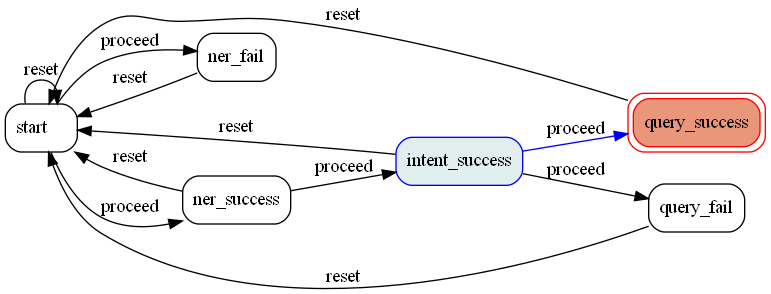

Реализуйте агента для ответов на вопросы по кино. Логика работы агента должна быть следующая:
* начинает в состоянии start;
* при вызове метода `proceed` в состоянии `start` вызывает `find_entity`, переходит в состояние `ner_success` и сохраняет найденное значение в виде атрибута `self.entity`, если сущность найдена, и переходит в `ner_fail` в противном случае;
* при вызове метода `proceed` в состоянии `ner_success` вызывает `find_intent`, переходит в состояние `intent_success` и сохраняет найденное значение в виде атрибута `self.intent`;
* при вызове метода `proceed` в состоянии `intent_success` вызывает `find_answer`, переходит в состояние `query_success` и сохраняет найденное значение в виде атрибута `self.answer`, если сущность найдена, и переходит в `query_fail` в противном случае;
* при вызове метода `reset` в любом состоянии переход в начальное состояние с сбрасывает значения атрибутов `self.entity`, `self.intent` и `self.answer`.

Если `find_entity` возвращает пустой результат или `score` меньше 0.3, то считайте, что сущность не найдена. Если find_answer возвращает score меньше 50, то считайте, что сущность не найдена.

Продемонстрируйте примеры работы агента.

- [ ] Проверено на семинаре

In [54]:
from transitions import Machine

In [59]:
class Agent:
  states = ["start", "ner_success", "ner_fail", "intent_success", "broken", "query_success", "query_fail"]
  def __init__(self):
    self.machine = Machine(model=self, states=self.states, initial="start")

    self.machine.add_transition(
        trigger="proceed",
        source="start",
        dest="ner_success",
        prepare="find_entity",
        unless="broken"
    )

    self.machine.add_transition(
        trigger="proceed",
        source="start",
        dest="ner_fail",
        conditions="broken"
    )

    self.machine.add_transition(
        trigger="proceed",
        source="ner_success",
        dest="intent_success",
        prepare="find_intent"
    )

    self.machine.add_transition(
        trigger="proceed",
        source="intent_success",
        dest="query_success",
        prepare="find_answer"
    )

    self.machine.add_transition(
        trigger="proceed",
        source="intent_success",
        dest="query_fail",
        conditions="broken"
    )

    self.machine.add_transition(
        trigger="reset",
        source=self.states,
        dest="start",
        prepare="cleaning"
    )

    self.entity = None
    self._broken = False

    self.db = db

  def find_intent(self, question):
      self.intent = get_intent(question)

  def find_entity(self, question):
      self.entity = get_entity(question)
      if self.entity['entity'] == '' or self.entity['score'] <= 0.3:
            print('Машина сломалась')
            self._broken = True

  def find_answer(self):
      self.answer = find_answer(self.entity['entity'], self.intent, self.db)
      if self.answer[1] <= 50:
          self._broken = True
      return self.answer[0]

  def answer_question(self, question):
      while not(self._broken):
          self.proceed(question)
          self.proceed(question)
          self.proceed()
          print(self.answer[0])
          break

  def cleaning(self):
      self.entity = None
      self.intent = None
      self._broken = False
      self.answer = None

  @property
  def broken(self):
    return self._broken

In [61]:
print(film_cameraman['question'][3])

question = film_cameraman['question'][3]
agent = Agent()
agent.answer_question(question)

Оператором фильма Любовь и голуби был
Владимир Меньшов (Vladimir Menshov)


In [67]:
print(film_director['question'][0])

question = film_director['question'][0]
agent = Agent()
agent.answer_question(question)

Кто продюсировал Джон Уик
Чад Стахелски (Chad Stahelski)


## Обратная связь
- [x] Хочу получить обратную связь по решению